# 12. Machine Learning - Predicción de default

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

Función para reporte de evaluación

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None):
    """
    Function for creating a performance report of a classification model.

    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.

    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    """

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, _ = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ["Negative", "Positive"]

        N_SUBPLOTS = 2
        PLOT_WIDTH = 20
        PLOT_HEIGHT = 5

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle("Performance Evaluation", fontsize=16)

        # plot 1: confusion matrix ----

        # preparing more descriptive labels for the confusion matrix
        cm_counts = [f"{val:0.0f}" for val in cm.flatten()]
        cm_percentages = [f"{val:.2%}" for val in cm.flatten()/np.sum(cm)]
        cm_labels = [f"{v1}\n{v2}" for v1, v2 in zip(cm_counts,cm_percentages)]
        cm_labels = np.asarray(cm_labels).reshape(2,2)

        sns.heatmap(cm, annot=cm_labels, fmt="", linewidths=.5, cmap="Greens",
                    square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": "center", "va": "center"})
        ax[0].set(xlabel="Predicted label",
                  ylabel="Actual label", title="Confusion Matrix")
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        # plot 2: ROC curve ----

        metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1], name="")
        ax[1].set_title("ROC Curve")
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), "ro",
                   markersize=8, label="Decision Point")
        ax[1].plot([0, 1], [0, 1], "r--")

    stats = {
        "accuracy": metrics.accuracy_score(y_test, y_pred),
        "precision": metrics.precision_score(y_test, y_pred),
        "recall": metrics.recall_score(y_test, y_pred),
        "specificity": (tn / (tn + fp)),
        "f1_score": metrics.f1_score(y_test, y_pred),
        "roc_auc": roc_auc,
    }

    return stats

Leer datos

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/erykml/Python-for-Finance-Cookbook-2E/refs/heads/main/Datasets/credit_card_default.csv", na_values="")

In [ ]:
df.head()

,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,...,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,...,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26.0,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57.0,Payed duly,Unknown,Payed duly,Unknown,Unknown,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_bal                   30000 non-null  int64  
 1   sex                         29850 non-null  object 
 2   education                   29850 non-null  object 
 3   marriage                    29850 non-null  object 
 4   age                         29850 non-null  float64
 5   payment_status_sep          30000 non-null  object 
 6   payment_status_aug          30000 non-null  object 
 7   payment_status_jul          30000 non-null  object 
 8   payment_status_jun          30000 non-null  object 
 9   payment_status_may          30000 non-null  object 
 10  payment_status_apr          30000 non-null  object 
 11  bill_statement_sep          30000 non-null  int64  
 12  bill_statement_aug          30000 non-null  int64  
 13  bill_statement_jul          300

Separar en entrenamiento y prueba

In [ ]:
X = df.copy()
y = X.pop("default_payment_next_month")

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

Procesar variables

In [ ]:
num_features = X_train.select_dtypes(include="number").columns.to_list()
cat_features = X_train.select_dtypes(include="object").columns.to_list()

num_pipeline = Pipeline(steps=[
    ("imputer", KNNImputer())
])

cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(categories=cat_list,
                             handle_unknown="error", drop="first"))
])

In [ ]:
cat_list

[['Female', 'Male'],
 ['University', 'Graduate school', 'High school', 'Others'],
 ['Single', 'Married', 'Others'],
 ['Payment delayed 2 months',
  'Payment delayed 1 month',
  'Unknown',
  'Payed duly',
  'Payment delayed 3 months',
  'Payment delayed 4 months',
  'Payment delayed 6 months',
  'Payment delayed 5 months',
  'Payment delayed 8 months',
  'Payment delayed 7 months'],
 ['Payment delayed 2 months',
  'Payed duly',
  'Unknown',
  'Payment delayed 3 months',
  'Payment delayed 1 month',
  'Payment delayed 4 months',
  'Payment delayed 5 months',
  'Payment delayed 7 months',
  'Payment delayed 6 months',
  'Payment delayed 8 months'],
 ['Payment delayed 3 months',
  'Payed duly',
  'Unknown',
  'Payment delayed 2 months',
  'Payment delayed 4 months',
  'Payment delayed 7 months',
  'Payment delayed 6 months',
  'Payment delayed 5 months',
  'Payment delayed 1 month',
  'Payment delayed 8 months'],
 ['Payment delayed 2 months',
  'Unknown',
  'Payed duly',
  'Payment delayed

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", num_pipeline, num_features),
        ("categorical", cat_pipeline, cat_features)
    ],
    remainder="drop"
)

Entrenar y evaluar árbol de decisión

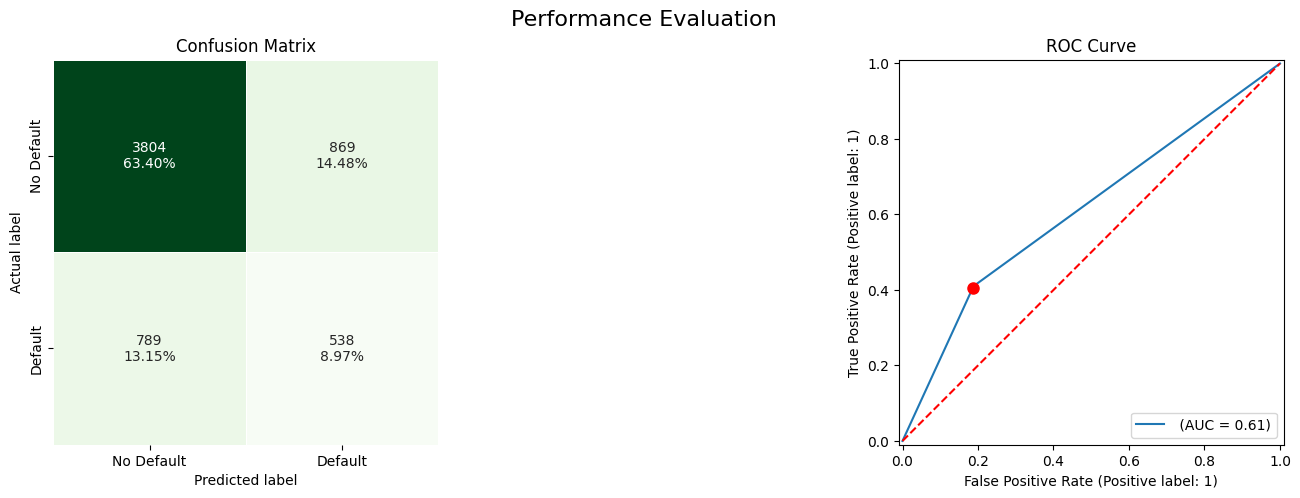

In [ ]:
tree_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", DecisionTreeClassifier(random_state=42))]
)

tree_pipeline.fit(X_train, y_train)

LABELS = ["No Default", "Default"]
tree_perf = performance_evaluation_report(tree_pipeline, X_test,
                                          y_test, labels=LABELS,
                                          show_plot=True)

In [ ]:
tree_perf

{'accuracy': 0.7236666666666667,
 'precision': 0.3823738450604122,
 'recall': 0.4054257724189902,
 'specificity': np.float64(0.8140380911619944),
 'f1_score': 0.393562545720556,
 'roc_auc': np.float64(0.6109321276921358)}

In [ ]:
tree_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['limit_bal', 'age',
                                                   'bill_statement_sep',
                                                   'bill_statement_aug',
                                                   'bill_statement_jul',
                                                   'bill_statement_jun',
                                                   'bill_statement_may',
                                                   'bill_statement_apr',
                                                   'previous_payment_sep',
                                                   'previous_payment_aug',
                                                   'previous_payment_jul',
                                                   'previous_paymen...
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '3 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '7 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '5 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '8 '
                                                                                              'months']],
                                                                                 drop='first'))]),
                                                  ['sex', 'education',
                                                   'marriage',
                                                   'payment_status_sep',
                                                   'payment_status_aug',
                                                   'payment_status_jul',
                                                   'payment_status_jun',
                                                   'payment_status_may',
                                                   'payment_status_apr'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [ ]:
X_scaled = tree_pipeline[:-1].transform(X_train)

In [ ]:
X_scaled

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 426962 stored elements and shape (24000, 72)>

## Random Forest y Xgboost

Entrenar y evaluar Random Forest y Xgboost

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

{'accuracy': 0.8123333333333334,
 'precision': 0.6397774687065368,
 'recall': 0.346646571213263,
 'specificity': np.float64(0.9445752193451744),
 'f1_score': 0.4496578690127077,
 'roc_auc': np.float64(0.7484596612423886)}

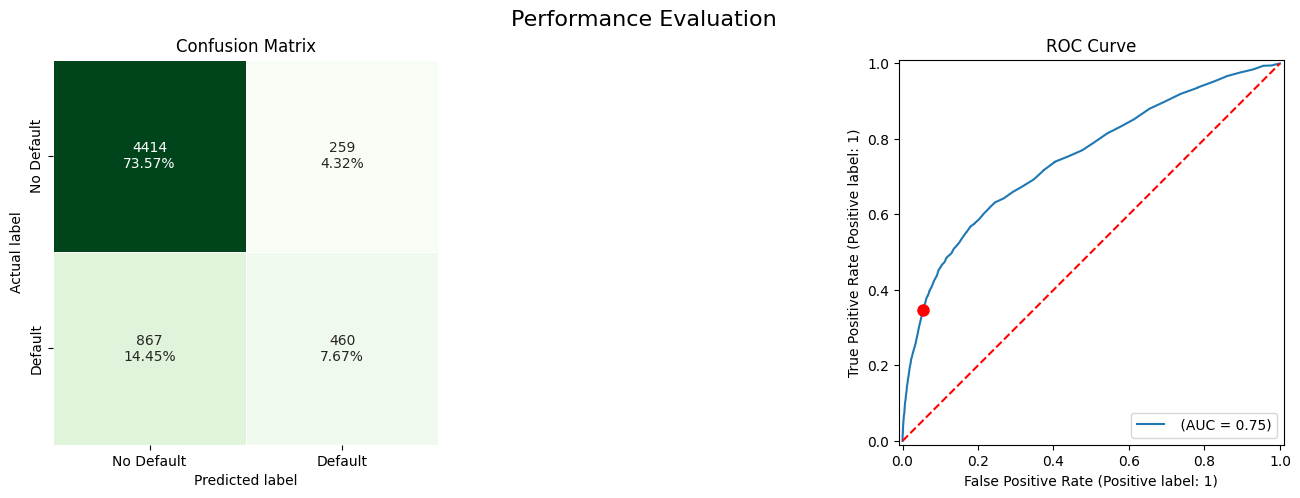

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", rf)]
)

rf_pipeline.fit(X_train, y_train)
rf_perf = performance_evaluation_report(rf_pipeline, X_test,
                                        y_test, labels=LABELS,
                                        show_plot=True)
rf_perf

{'accuracy': 0.81,
 'precision': 0.617906683480454,
 'recall': 0.36925395629238883,
 'specificity': np.float64(0.9351594264926172),
 'f1_score': 0.46226415094339623,
 'roc_auc': np.float64(0.7574006167644266)}

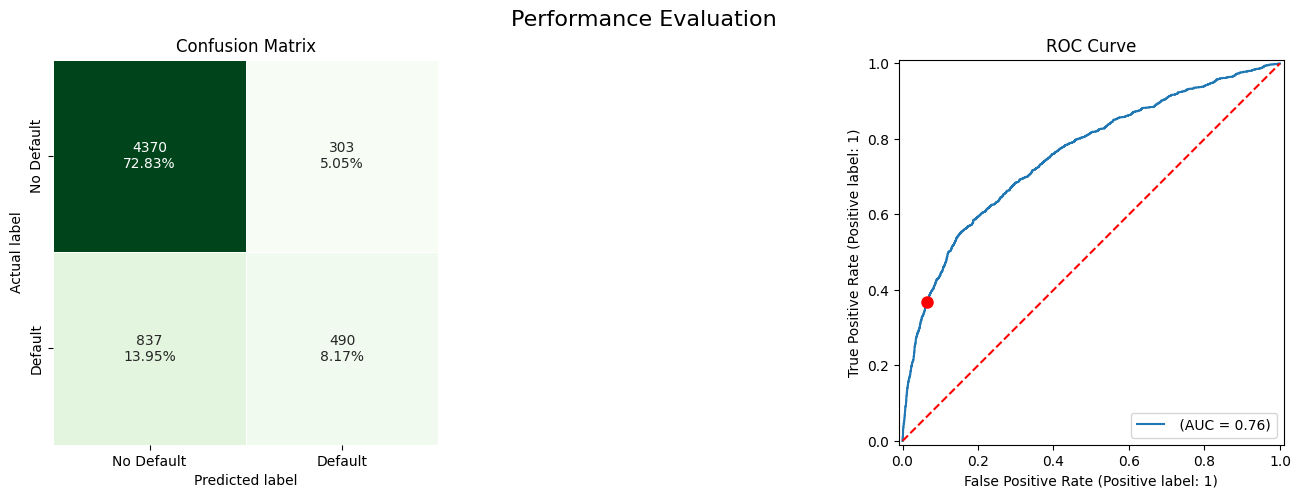

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", xgb)]
)

xgb_pipeline.fit(X_train, y_train)
xgb_perf = performance_evaluation_report(xgb_pipeline, X_test,
                                         y_test, labels=LABELS,
                                         show_plot=True)
xgb_perf

## Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
import numpy as np

N_SEARCHES = 10
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

In [ ]:
xgb_param_grid = {
    "classifier__n_estimators": np.linspace(100, 500, 5, dtype=int),
    "classifier__learning_rate": np.arange(0.05, 0.31, 0.05),
    "classifier__max_depth": np.arange(3, 11, 1, dtype=int),
    "classifier__min_child_weight": np.arange(1, 8, 1, dtype=int),
    "classifier__colsample_bytree": np.linspace(0.3, 1, 7)
}

In [ ]:
xgb_rs =  RandomizedSearchCV(xgb_pipeline, xgb_param_grid, scoring="recall",
                             cv=k_fold, n_jobs=-1, verbose=1,
                             n_iter=N_SEARCHES, random_state=42)

xgb_rs.fit(X_train, y_train)

print(f"Best parameters: {xgb_rs.best_params_}")
print(f"Recall (Training set): {xgb_rs.best_score_:.4f}")
print(f"Recall (Test set): {metrics.recall_score(y_test, xgb_rs.predict(X_test)):.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'classifier__n_estimators': np.int64(100), 'classifier__min_child_weight': np.int64(6), 'classifier__max_depth': np.int64(10), 'classifier__learning_rate': np.float64(0.1), 'classifier__colsample_bytree': np.float64(0.7666666666666666)}
Recall (Training set): 0.3686
Recall (Test set): 0.3557


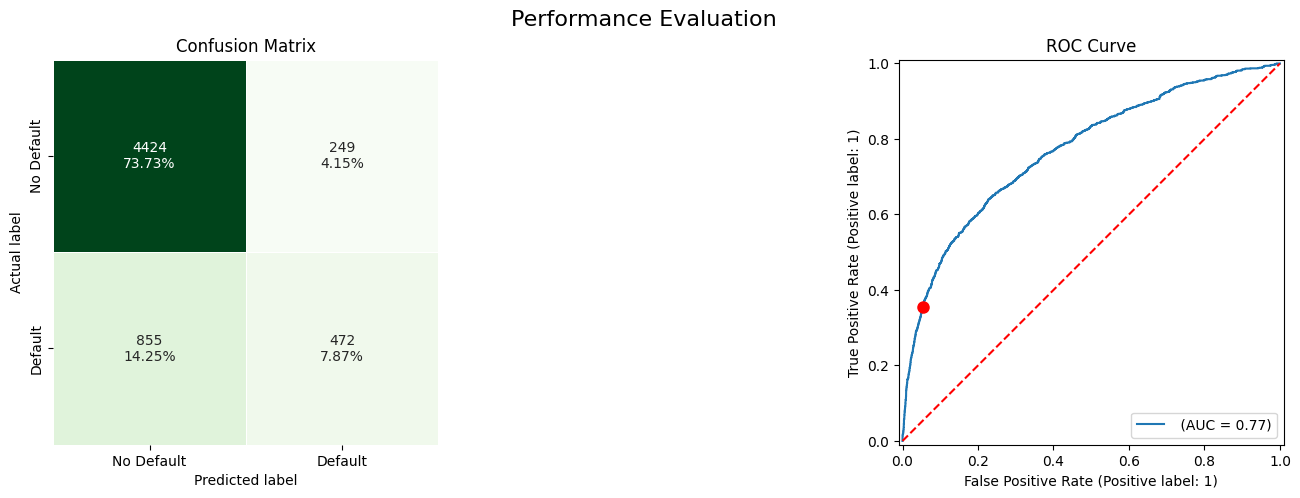

In [ ]:
xgb_rs_perf = performance_evaluation_report(xgb_rs, X_test,
                                            y_test, labels=LABELS,
                                            show_plot=True)

## Probar distintos umbrales

In [ ]:
y_pred_proba = xgb_rs.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.13284685, 0.12800911, 0.20624079, ..., 0.08777721, 0.13541837,
       0.04430752], dtype=float32)

(array([2435., 1533.,  613.,  404.,  274.,  191.,  173.,  184.,  164.,
          29.]),
 array([0.00641144, 0.10376066, 0.20110987, 0.29845908, 0.39580831,
        0.49315754, 0.59050673, 0.68785596, 0.78520519, 0.88255441,
        0.97990364]),
 <BarContainer object of 10 artists>)

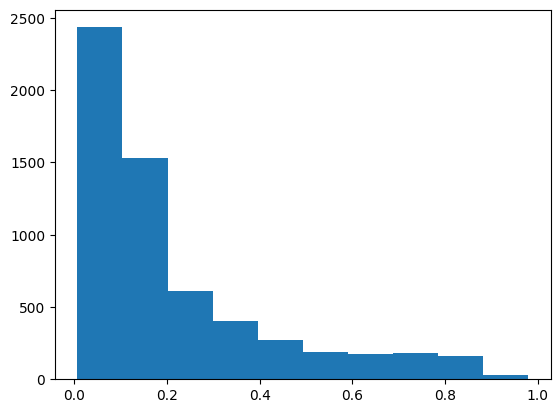

In [ ]:
plt.hist(y_pred_proba)

In [ ]:
thresholds = np.arange(0, 1, 0.2)
print("Shape of thresholds array:", thresholds.shape)
print("First 5 thresholds:", thresholds[:5])

Shape of thresholds array: (5,)
First 5 thresholds: [0.  0.2 0.4 0.6 0.8]


0.0


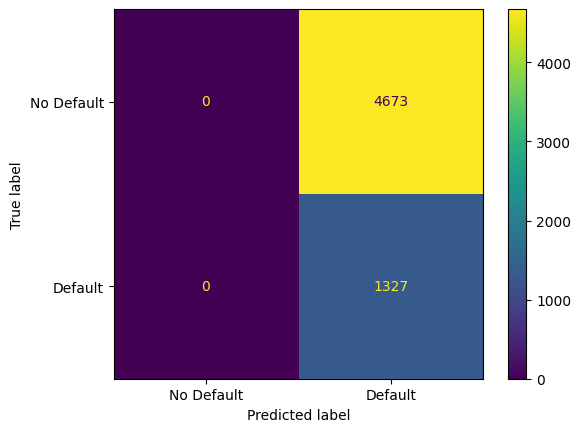

0.2


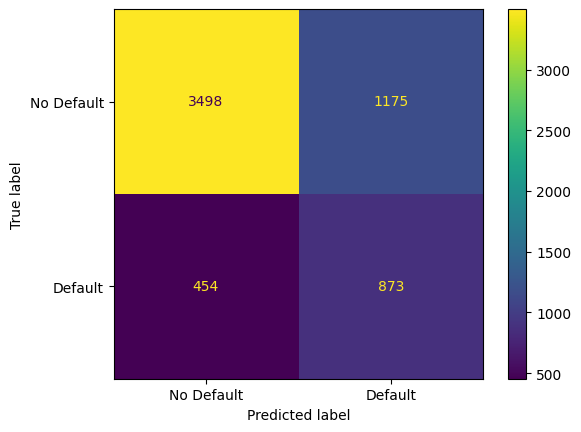

0.4


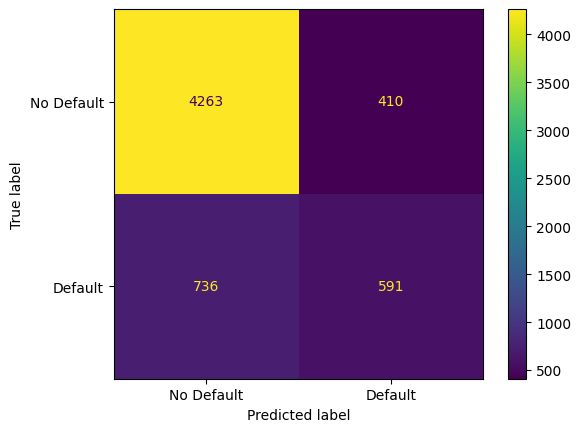

0.6000000000000001


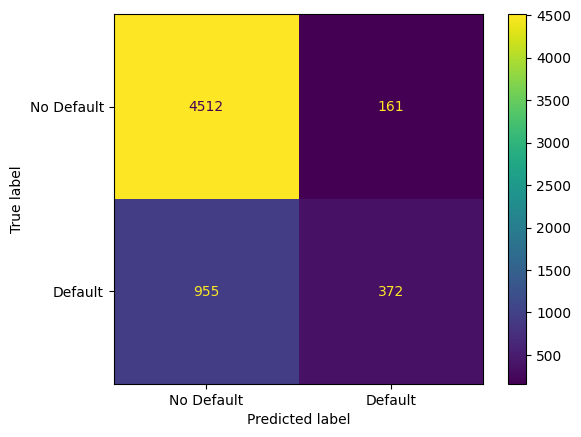

0.8


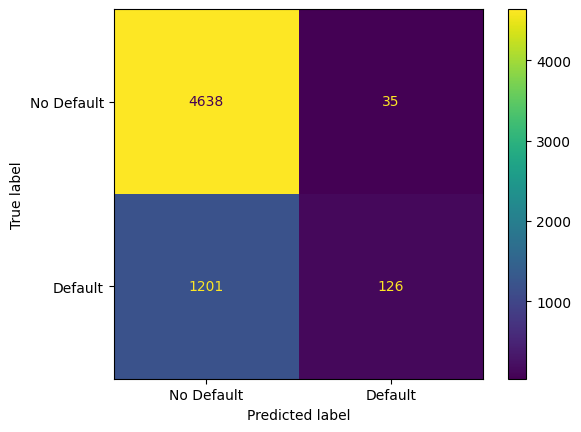

In [ ]:
for threshold in thresholds:
    # Convert predicted probabilities to binary predictions based on the current threshold
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    print(threshold)
    # Calculate evaluation metrics
    metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_threshold,
    display_labels=['No Default', 'Default'],
    )
    plt.show()